# RBA SOMP Forecasts

## Set-up

In [1]:
# system imports
import io
from dataclasses import dataclass
from pathlib import Path
from typing import TypeAlias, cast

# analytic imports
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from plotting import clear_chart_dir, finalise_plot, set_chart_dir

In [2]:
# local imports
import abs_data_capture
import common
import rba_data_capture
import utility

In [3]:
# plotting constants
CHART_DIR = "./CHARTS/SOMP"
Path(CHART_DIR).mkdir(parents=True, exist_ok=True)
clear_chart_dir(CHART_DIR)
set_chart_dir(CHART_DIR)
plt.style.use("fivethirtyeight")
SHOW = True

## Collect and reorganise SOMP data

### Typing information

In [4]:
# Note: use NewType in the future when moved to Python 3.12

# dict holds data by report dates
# rows in df are subject domains columns are projection dates
DateSompType: TypeAlias = dict[str, pd.DataFrame]

# dict holds data by subject domain
# rows in df are projection dates, columns are report dates
DomainSompType: TypeAlias = dict[str, pd.DataFrame]

### Get raw SOMP tables

In [5]:
# Note: inclusive search terms:
START_YEAR = 2019
STOP_YEAR = 2024  # - this will need updating from year to year

In [6]:
def data_cleaning(frame: pd.DataFrame) -> pd.DataFrame:
    """Preliminary data cleaning for the raw SOMP
    data captured from the RBA website."""

    for col in frame.columns:

        # convert text fractions to decimals
        frame[col] = (
            frame[col]
            .astype(str)
            .str.replace("¼", ".25")
            .str.replace("½", ".5")
            .str.replace("¾", ".75")
            .str.replace("−", "-")
        )

        # make to NaN all non-numeric data
        frame[col] = pd.to_numeric(frame[col], errors="coerce")

    # delete all-NaN rows - Needed for Feb 24 report
    frame = frame = frame.dropna(how="all", axis="index")

    # remove odd footnotes from index introduced in Feb 2024
    # and standardize the case used in the index
    # (because of case mismatch before and after Feb 2024)
    frame.index = frame.index.str.replace(r"\([a-z]\)$", "", regex=True).str.title()

    return frame

In [7]:
def collect_somp_data() -> DateSompType:
    """Collect raw SOMP data, as presented in these SOMP
    reports. Returns one table for each report in a dict."""

    cache_dir = "./RBA_SOMP_CACHE"
    cache = Path(cache_dir)
    cache.mkdir(parents=True, exist_ok=True)
    q_start = {"feb": 1, "may": 2, "aug": 3, "nov": 4}

    pool: DateSompType = {}
    for year in range(START_YEAR, STOP_YEAR + 1):
        for qtr, q_number in q_start.items():

            # get URL
            url = (
                (
                    "https://www.rba.gov.au/publications"
                    f"/smp/{year}/{qtr}/forecasts.html"
                )
                if year < 2024
                else (
                    # Change of RBA data location in Feb 2024 ...
                    "https://www.rba.gov.au/publications"
                    f"/smp/{year}/{qtr}/outlook.html"
                )
            )

            # get the HTML text found at URL
            try:
                file = common.get_file(url, cache)
            except common.HttpError:
                print(f"Did not get: {year}-{qtr}")
                continue

            # get and clean relevant table from the HTML
            frame_list = pd.read_html(cast(str, io.BytesIO(file)), index_col=0)
            relevant_table = 0
            frame = data_cleaning(frame_list[relevant_table])

            # save the table into a dict
            index = f"{year}-Q{q_number}"
            pool[index] = frame

    return pool

In [8]:
raw_somp = collect_somp_data()

Retrieving data from cache: RBA_SOMP_CACHE/a1379dd0a92bd4626c9f86a01864ca7a--forecasts.html
Retrieving data from cache: RBA_SOMP_CACHE/73d98da9e9b4cb61f9a2b7ec484666c8--forecasts.html
Retrieving data from cache: RBA_SOMP_CACHE/dbc5bd06d495148c7ec5d9f423911d09--forecasts.html
Retrieving data from cache: RBA_SOMP_CACHE/9a5ae921c14572463601b945bf77e2ac--forecasts.html
Retrieving data from cache: RBA_SOMP_CACHE/67549187a6a3d7fffe7a792631b7b08d--forecasts.html
Retrieving data from cache: RBA_SOMP_CACHE/b37e01367aeff06d7982501f07bb0dbe--forecasts.html
Retrieving data from cache: RBA_SOMP_CACHE/6c8ad34d268f122e9d7f2dc5231e1fdc--forecasts.html
Retrieving data from cache: RBA_SOMP_CACHE/bab514a8e41482bad760e1d86696c366--forecasts.html
Retrieving data from cache: RBA_SOMP_CACHE/e8497feee2f9cc80ff8502b518709a2c--forecasts.html
Retrieving data from cache: RBA_SOMP_CACHE/889b66a1af4e66f440c092d128094cf3--forecasts.html
Retrieving data from cache: RBA_SOMP_CACHE/935401f104a40cf7282a69bdc3c647fd--for

### Reorganise SOMP data

In [9]:
def reorganise_somp(inputs: dict[str, pd.DataFrame]) -> DomainSompType:
    """Reorganise the SOMP data
    from tables by date to tables by domain."""

    ue = "Unemployment Rate"
    pool: DomainSompType = {}
    for index, frame in inputs.items():
        for item in frame.index:
            if item[0] == "(":
                continue  # ignore footnotes
            row = frame.loc[item]
            row.name = index
            item_adj = ue if ue in item else item
            if item_adj not in pool:
                pool[item_adj] = pd.DataFrame(row)
            else:
                pool[item_adj] = pd.concat([pool[item_adj], pd.DataFrame(row)], axis=1)

    for table in pool.values():
        table.columns = pd.PeriodIndex(table.columns, freq="Q-NOV")
        table.index = pd.PeriodIndex(table.index, freq="Q-DEC")

    return pool

In [10]:
somp: DomainSompType = reorganise_somp(raw_somp)
somp.keys()

dict_keys(['Gross Domestic Product', 'Household Consumption', 'Dwelling Investment', 'Business Investment', 'Public Demand', 'Gross National Expenditure', 'Imports', 'Exports', 'Real Household Disposable Income', 'Terms Of Trade', 'Major Trading Partner (Export-Weighted) Gdp', 'Unemployment Rate', 'Employment', 'Wage Price Index', 'Nominal (Non-Farm) Average Earnings Per Hour', 'Trimmed Mean Inflation', 'Consumer Price Index', 'Hours-Based Underutilisation Rate (Quarterly, %)', 'Nominal Average Earnings Per Hour (Non-Farm)', 'Cash Rate (%)', 'Trade-Weighted Index (Index)', 'Brent Crude Oil Price (Us$/Bbl)', 'Estimated Resident Population', 'Labour Productivity', 'Household Savings Rate (%)', 'Real Wage Price Index', 'Real Average Earnings Per Hour (Non-Farm)'])

## Get ABS data

### Typing information

In [11]:
@dataclass
class Selector:
    """Data used to select and process an ABS series."""

    catalog_id: str
    table: str
    orig_sa: str
    search1: str
    search2: str
    calc_growth: bool


# Note: use NewType in the future when moved to Python 3.12
MeasureType: TypeAlias = dict[str, Selector]
AbsDataType: TypeAlias = dict[str, pd.Series]

### Data retrieval 

In [12]:
def get_abs(measure: MeasureType) -> AbsDataType:
    """Return a dictionary of Series data from the ABS,
    Once series for each item in the measure dictionary."""

    pool = {}
    (
        did_col,
        _,  # id_col
        table_col,
        type_col,
        _,  # unit_col
        _,  # tdesc_col
    ) = abs_data_capture.get_meta_constants()

    for name, select in measure.items():
        print(name)

        # get the ABS data
        data_dict = abs_data_capture.get_abs_meta_and_data(select.catalog_id)
        _, _, meta_data = abs_data_capture.get_fs_constants(select.catalog_id)
        meta = data_dict[meta_data]
        data = data_dict[select.table]

        # get the specific series we want to plot
        search_terms = {
            select.table: table_col,
            {"SA": "Seasonally Adjusted", "Orig": "Original"}[select.orig_sa]: type_col,
            select.search1: did_col,
            select.search2: did_col,
        }
        series = data[abs_data_capture.find_id(meta, search_terms, verbose=True)[0]]
        index = series.index
        if select.calc_growth:
            periods = 4 if index.freqstr[0] == "Q" else 12
            series = (series / series.shift(periods) - 1) * 100.0
        pool[name] = series

    return pool

## Plotting

### Utility functions

In [13]:
def plot_somp(
    ax: mpl.axes.Axes,
    somp_df: pd.DataFrame,
    last_n: int = 0,
) -> None:
    """Add the quarterly SOMP forecasts to a plot."""

    df = somp_df.copy()  # non destructive
    df = df[df.columns[-last_n:]] if last_n else df

    n_colours = len(df.columns)
    gradient = np.linspace(0, 1, n_colours)
    cmap = cmap = plt.get_cmap("viridis")
    colors = (
        cmap(gradient)
        if last_n == 0 or last_n > 2
        else ("cornflowerblue", "darkorange")
    )
    xy = set()
    last = df.columns[-1]

    for col, color in zip(df.columns, colors):
        s = df[col].dropna().astype(float)  # kludge
        if s.index[0].year < START_YEAR:
            continue
        color = "darkred" if col == last else color
        s.plot(ax=ax, lw=1.5, c=color, label=str(col)[2:])
        x, y = s.index[-1], s.iloc[-1]
        # let's minimise over-plotting of text
        va = "bottom" if (x, y) not in xy else "top"
        ax.text(x=x, y=y, s=str(col)[2:], fontsize=6, va=va)
        xy.add((x, y))

In [14]:
def plot_annual_growth(
    growth_data: AbsDataType,
    measures: MeasureType,
    somp_data: DomainSompType,
    ylabel: str = "Growth (per cent per year)",
) -> None:
    """Produce a plot for the selected input."""

    recency = (0, 2)
    tags = ("", "last-2")

    for name, abs_series in growth_data.items():
        (cat, table, season) = (
            measures[name].catalog_id,
            measures[name].table,
            measures[name].orig_sa,
        )
        somp_df = somp_data[name]
        if abs_series.index.freqstr[0] == "M":
            somp_df = utility.qtly_to_monthly(somp_df)
            # re-index from end to make mid quarter)
            somp_df.index = somp_df.index - 1  # month

        for last_n, tag in zip(recency, tags):
            _, ax = plt.subplots()
            plot_somp(ax, somp_df, last_n=last_n)
            abs_series[abs_series.index.year >= START_YEAR - 1].plot(
                ax=ax, lw=3.5, color="red", alpha=0.65, label="ABS"
            )

            # Correctly label modeling assumptions and memo items
            title = f"{name} (with RBA SOMP forecasts)"
            if name in (
                'Cash Rate (%)', 
                'Trade-Weighted Index (Index)', 
                'Brent Crude Oil Price (Us$/Bbl)', 
                'Estimated Resident Population',
            ):
                title = title.replace('forecasts', "assumptions");
            if name in (
                'Labour Productivity', 
                'Household Savings Rate (%)', 
                'Real Wage Price Index', 
                'Real Average Earnings Per Hour (Non-Farm)'
            ):
                title = title.replace('forecasts', "memo items");
            
            fold_line_threshold = 55
            if len(title) > fold_line_threshold:
                # replace the last occurrence
                old = " ("
                new = "\n("
                title = (title[::-1].replace(old[::-1], new[::-1], 1))[::-1]
            finalise_plot(
                ax,
                title=title,
                ylabel=ylabel,
                lfooter=f"Australia. {season} series.",
                rfooter=f"RBA SOMP. ABS {cat} {table}.",
                legend={"ncols": 1, "loc": "center left", "fontsize": "xx-small"},
                y0=True,
                tag=tag,
                show=SHOW,
            )

### Annual Growth Measures

In [15]:
growth_measures: MeasureType = {
    "Gross Domestic Product": Selector(
        catalog_id="5206",
        table="1",
        orig_sa="SA",
        search1="Chain volume measures ;",
        search2="Gross domestic product:",
        calc_growth=True,
    ),
    "Household Consumption": Selector(
        catalog_id="5206",
        table="8",
        orig_sa="SA",
        search1="Chain volume measures ;",
        search2="FINAL CONSUMPTION EXPENDITURE:",
        calc_growth=True,
    ),
    "Dwelling Investment": Selector(
        catalog_id="5206",
        table="2",
        orig_sa="SA",
        search1="Private ;  Gross fixed capital formation - Dwellings - Total ;",
        search2="Private ;  Gross fixed capital formation - Dwellings - Total ;",
        calc_growth=True,
    ),
    "Gross National Expenditure": Selector(
        catalog_id="5206",
        table="2",
        orig_sa="SA",
        search1="Gross national expenditure ;",
        search2="Gross national expenditure ;",
        calc_growth=True,
    ),
    "Imports": Selector(
        catalog_id="5206",
        table="2",
        orig_sa="SA",
        search1="Imports of goods and services ;",
        search2="Imports of goods and services ;",
        calc_growth=True,
    ),
    "Exports": Selector(
        catalog_id="5206",
        table="2",
        orig_sa="SA",
        search1="Exports of goods and services ;",
        search2="Exports of goods and services ;",
        calc_growth=True,
    ),
    "Trimmed Mean Inflation": Selector(
        catalog_id="6401",
        table="8",
        orig_sa="SA",
        search1="Percentage Change from Corresponding Quarter of Previous Year",
        search2="Trimmed Mean ;  Australia ;",
        calc_growth=False,
    ),
    "Consumer Price Index": Selector(
        catalog_id="6401",
        table="2",
        orig_sa="Orig",
        search1="Percentage Change from Corresponding Quarter of Previous Year",
        search2="All groups CPI ;  Australia ;",
        calc_growth=False,
    ),
    "Wage Price Index": Selector(
        catalog_id="6345",
        table="1",
        orig_sa="SA",
        search1="Percentage Change From Corresponding Quarter of Previous Year",
        search2="Australia ;  Total hourly rates of pay excluding bonuses ;  "
        + "Private and Public ;  All industries ;",
        calc_growth=False,
    ),

    'Estimated Resident Population': Selector(
        catalog_id="3101",
        table="1",
        orig_sa="Orig",
        search1="Percentage ERP Change Over Previous Year ;  Australia ;",
        search2="Percentage ERP Change Over Previous Year ;  Australia ;",
        calc_growth=False,
    ),
    
    # "Business Investment": (
    #
    #    # -- Needs work - ‘Business investment’ and ‘Public demand’ have been
    #    # adjusted to exclude the effects of net sales of existing capital
    #    # assets between the private and other (public and external) sectors.
    #
    #    "5206",
    #    "2",
    #    "SA",
    #    "Private ;  Gross fixed capital formation ;",
    #    "Private ;  Gross fixed capital formation ;",
    #    True,
    # ),
    # "Public Demand": (
    #
    #    # Needs work - see above
    #
    #    "5206",
    #    "24",
    #    "SA",
    #    "Public ;  Final demand: Chain volume measures ;",
    #    "Public ;  Final demand: Chain volume measures ;",
    #    True,
    # ),
    # - Series stops with 23Q4 ... Replaced by
    #  'Real Average Earnings Per Hour (Non-Farm)'
    #   in 24Q1 SOMP
    # "Nominal (Non-Farm) Average Earnings Per Hour": (
    #    "5206",
    #    "24",
    #    "SA",
    #    "Current prices ;",
    #    "Non-farm compensation of employees per hour:",
    #    True,
    # ),
}

Gross Domestic Product
Found URL for a ZIP file on ABS web page
Retrieving data from cache: ABS_CACHE/5017be8287dea982b865689c39593eff--All_time_series_workbooks.zip
Extracting DataFrames from the zip-file ...
Household Consumption
Dwelling Investment
Gross National Expenditure
Imports
Exports
Trimmed Mean Inflation
Found URL for a ZIP file on ABS web page
Retrieving data from cache: ABS_CACHE/009cab4e5b98e8a0836b649cecbac43a--All-Time-Series-Spreadsheets.zip
Extracting DataFrames from the zip-file ...
Consumer Price Index
Wage Price Index
Found URL for a ZIP file on ABS web page
Retrieving data from cache: ABS_CACHE/6052268df887aaf3a0774941b419dc9b--Time-series-spreadsheets-all.zip
Extracting DataFrames from the zip-file ...
Estimated Resident Population
Found URL for a ZIP file on ABS web page
Retrieving data from cache: ABS_CACHE/319496caf5686125e339585d019fe765--All20time20series20spreadsheets.zip
Extracting DataFrames from the zip-file ...


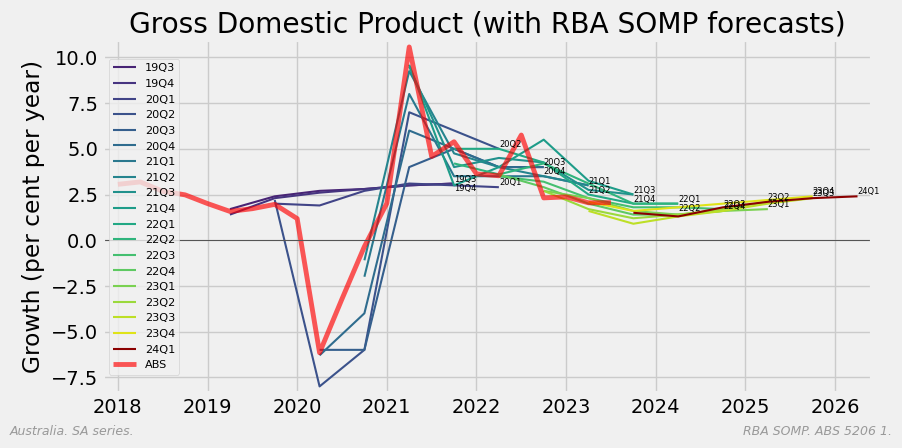

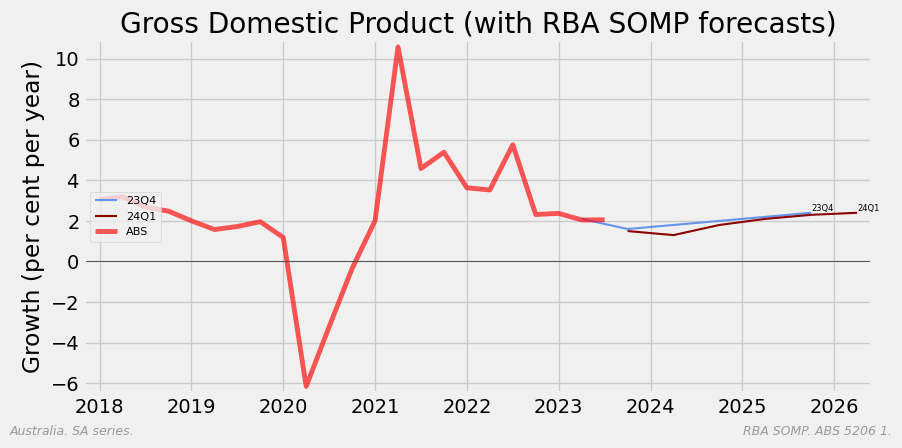

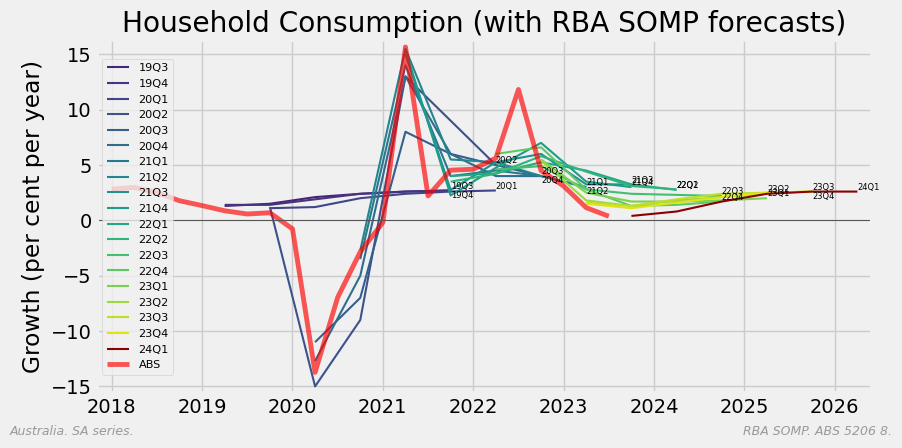

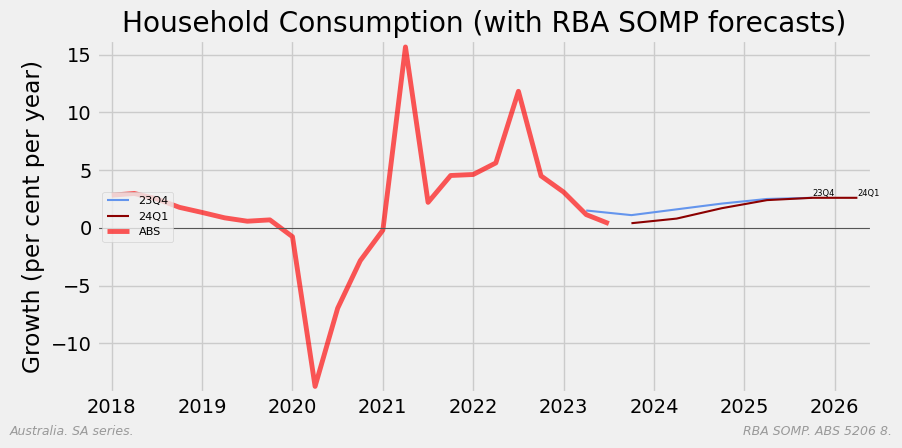

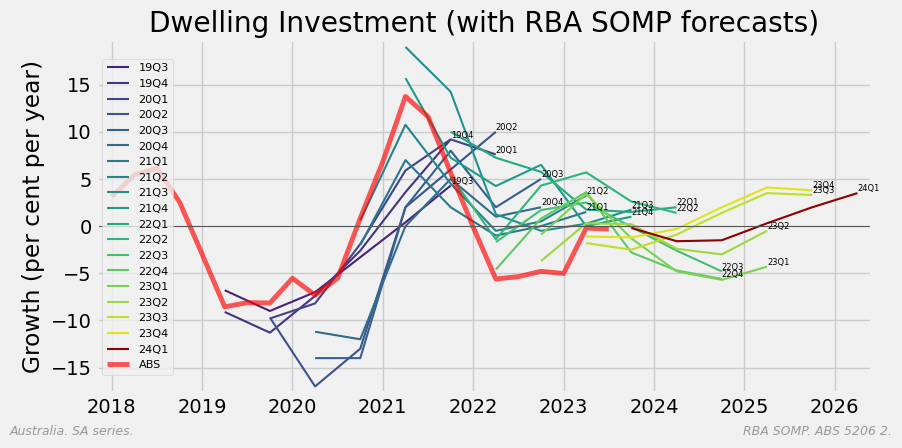

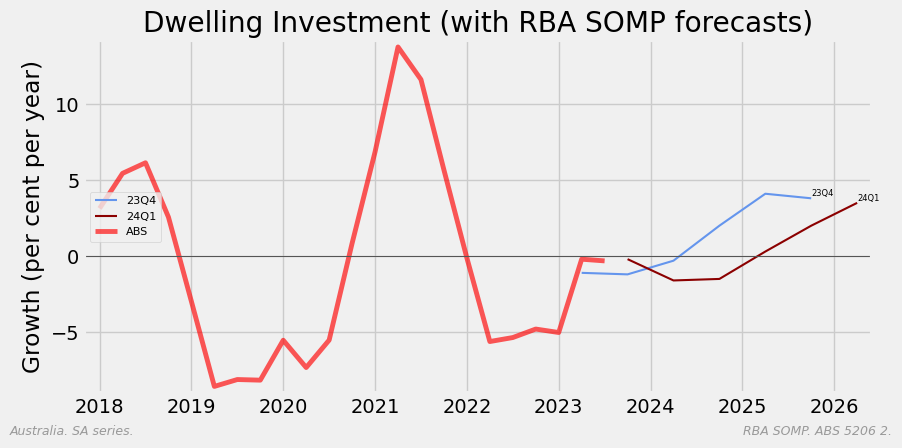

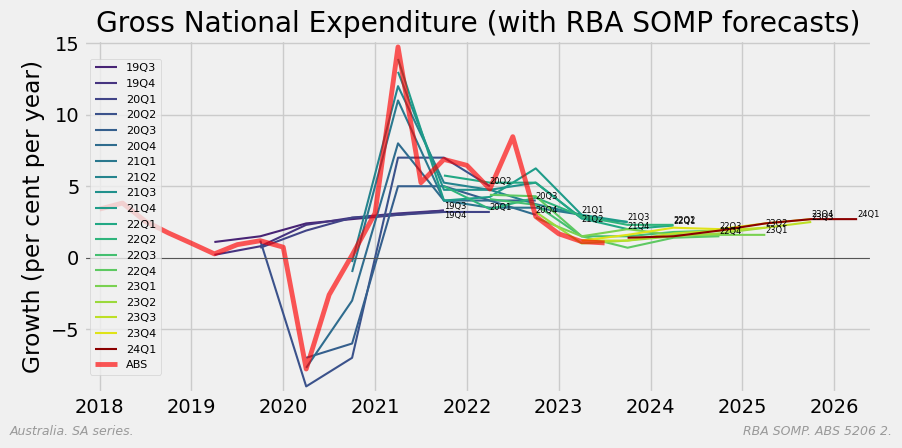

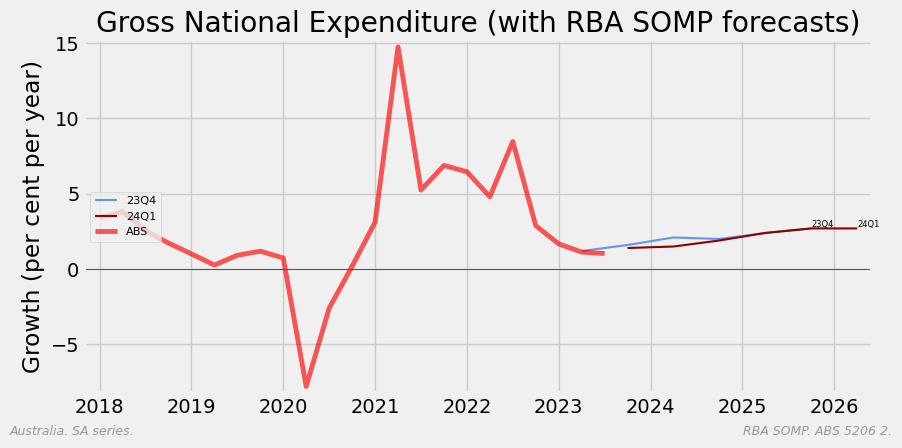

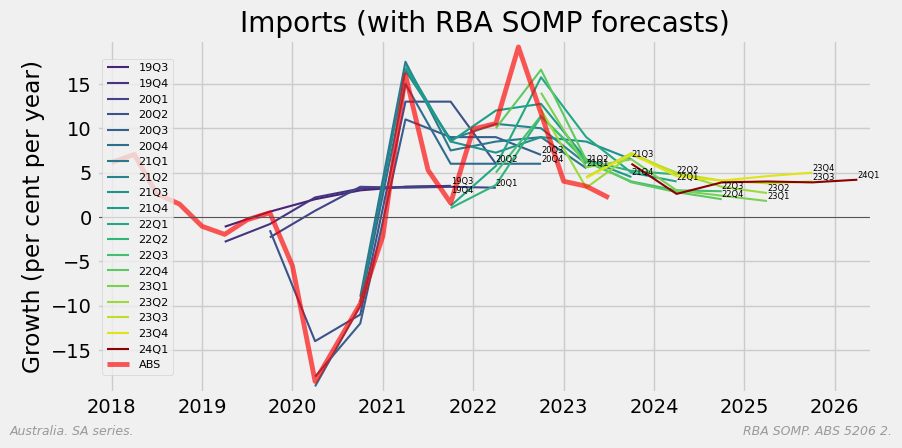

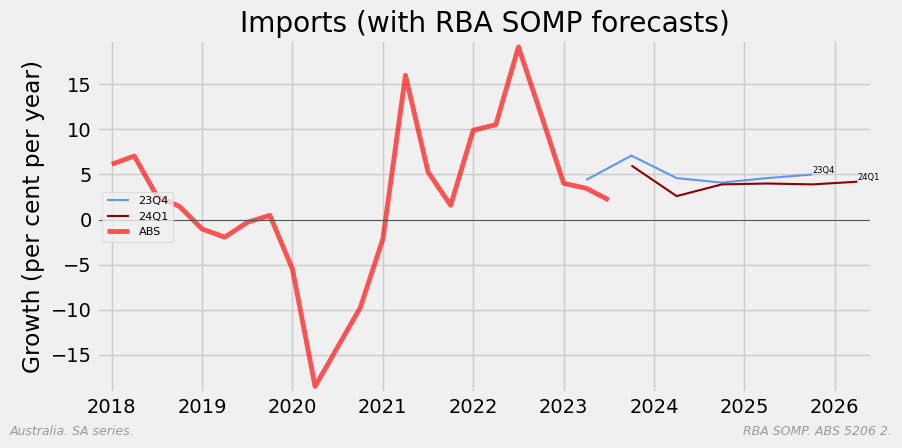

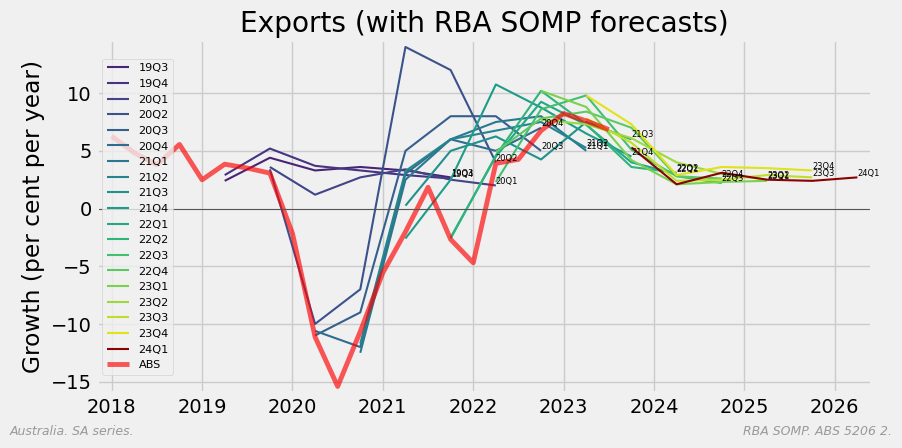

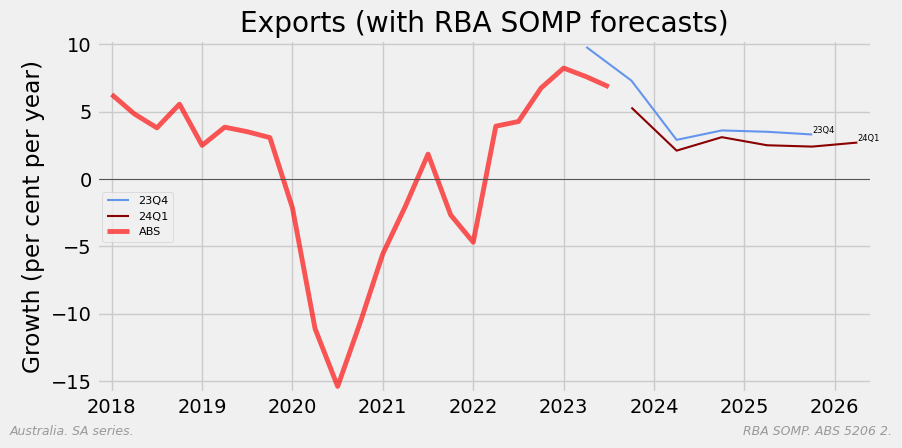

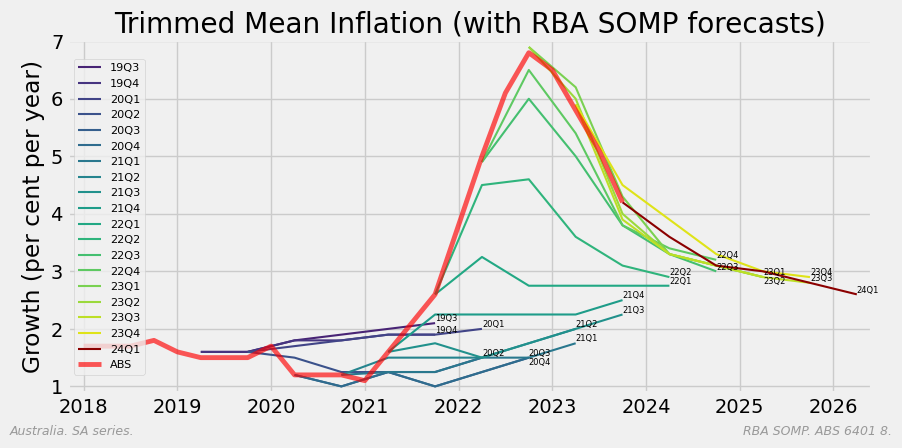

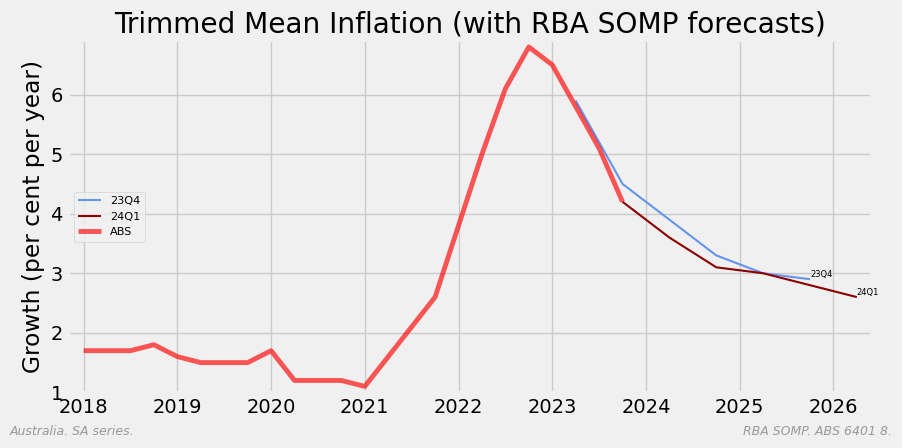

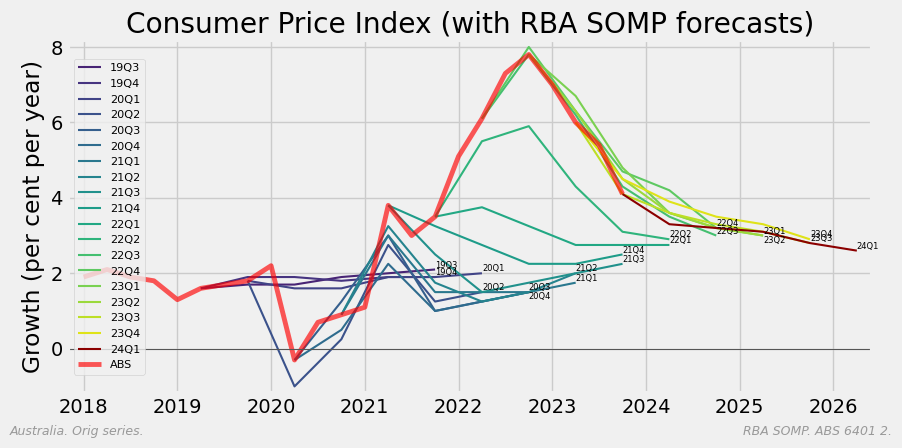

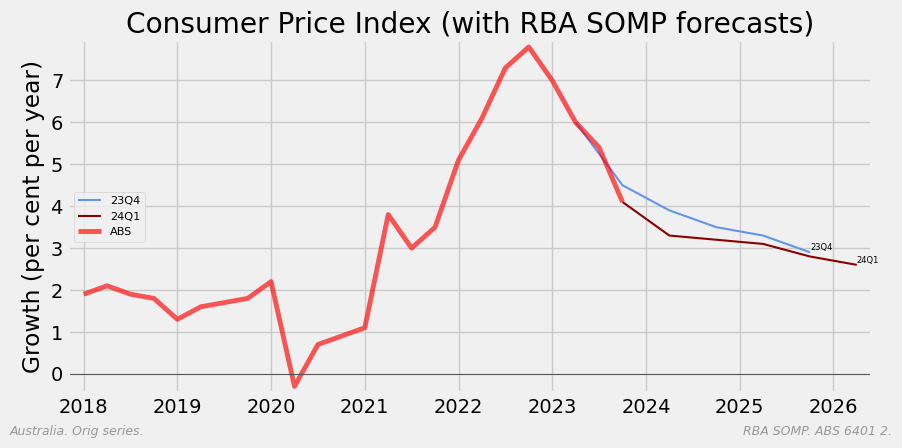

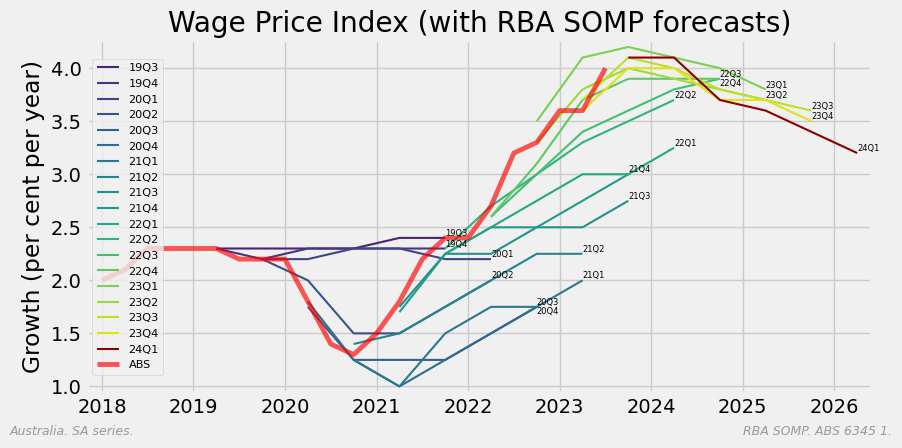

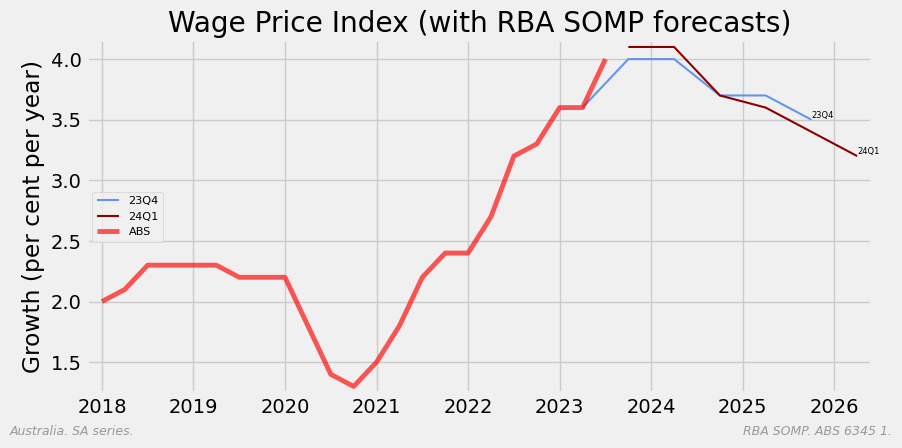

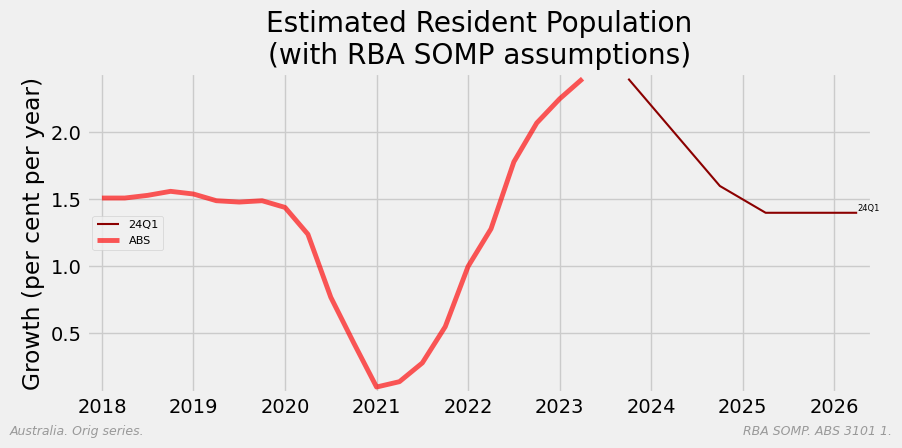

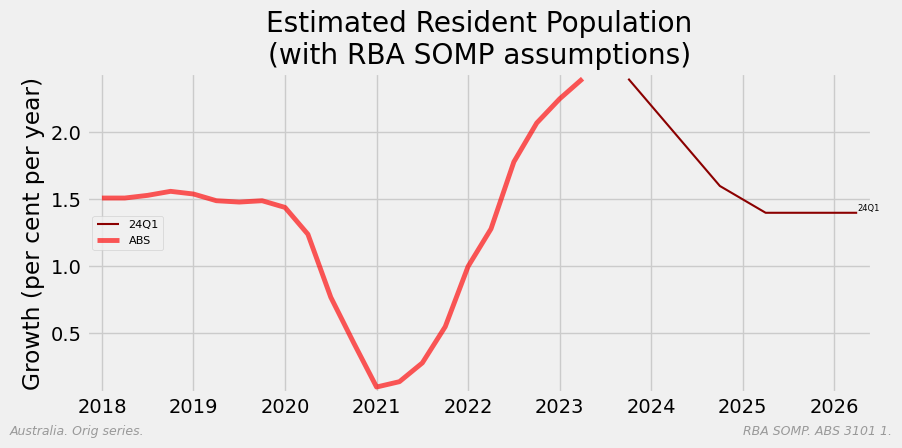

In [16]:
plot_annual_growth(get_abs(growth_measures), growth_measures, somp)

### Real household disposable income
See table H from the RBA Statistical Tables: 'Real household disposable income' is household disposable income after the deduction of interest payments, deflated by the implicit price deflator for household consumption expenditure; includes income from unincorporated enterprises.

In [17]:
di_measures: MeasureType = {
    "Disposable income": Selector(
        catalog_id="5206",
        table="20",
        orig_sa="SA",
        search1="GROSS DISPOSABLE INCOME ;",
        search2="GROSS DISPOSABLE INCOME ;",
        calc_growth=False,
    ),
    "HFCE deflator": Selector(
        catalog_id="5206",
        table="5",
        orig_sa="SA",
        search1=" ",
        search2="Households ;  Final consumption expenditure ;",
        calc_growth=False,
    ),
}

In [18]:
def plot_di(somp_data: DomainSompType):
    """Plot disposable income"""

    di_data = get_abs(di_measures)
    deflator = di_data["HFCE deflator"] / 100.0
    rhdi = di_data["Disposable income"] / deflator
    growth = (rhdi / rhdi.shift(4) - 1) * 100.0
    growth_data = {"Real Household Disposable Income": growth}
    fake_measure: MeasureType = {
        "Real Household Disposable Income": Selector(
            catalog_id="5206",
            table=", ".join([x.table for x in di_measures.values()]),
            orig_sa="SA",
            search1="",
            search2="",
            calc_growth=True,
        ),
    }

    print(fake_measure)
    plot_annual_growth(growth_data, fake_measure, somp_data)

Disposable income
HFCE deflator
{'Real Household Disposable Income': Selector(catalog_id='5206', table='20, 5', orig_sa='SA', search1='', search2='', calc_growth=True)}


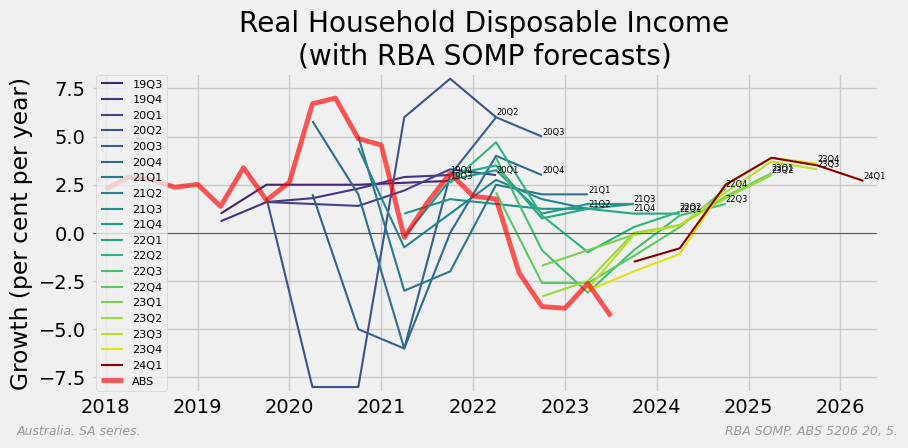

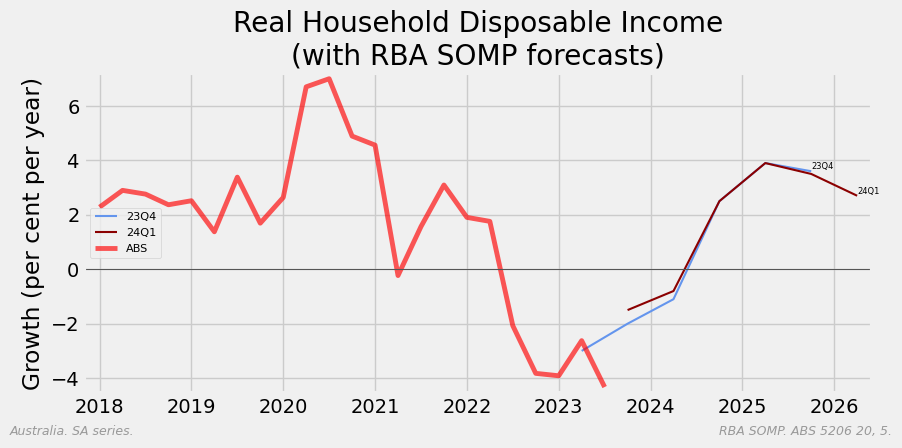

In [19]:
plot_di(somp)

### Unemployment rate

Note: The UE rate in the SMOP is a quarterly figure, which we are plotting against a monthly ABS series. This is not quite apples and oranges.

In [20]:
# Force UE data to be quarterly
UE_QUARTERLY = False

def plot_ue():
    """Plot the SOMP UE forecasts."""

    ue_text = "Unemployment Rate"
    ue_measure = {
        ue_text: Selector(
            catalog_id="6202",
            table="1",
            orig_sa="SA",
            search1="Unemployment rate ;",
            search2="Persons",
            calc_growth=False,
        ),
    }

    ue_data = get_abs(ue_measure)

    if UE_QUARTERLY:
        #  Convert monthly UE data to Quarterly.
        ue_data[ue_text] = utility.monthly_to_qtly(ue_data[ue_text])

    plot_annual_growth(ue_data, ue_measure, somp, ylabel="Unemployment Rate (%)")

Unemployment Rate
Found URL for a ZIP file on ABS web page
Retrieving data from cache: ABS_CACHE/842830b693f9b921bbe3abd5bbd8f4d8--p6202_all_monthly_spreadsheets.zip
Extracting DataFrames from the zip-file ...


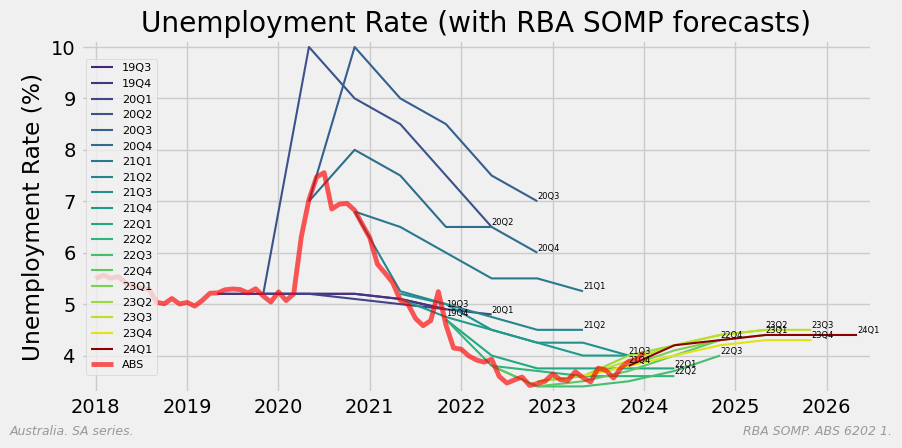

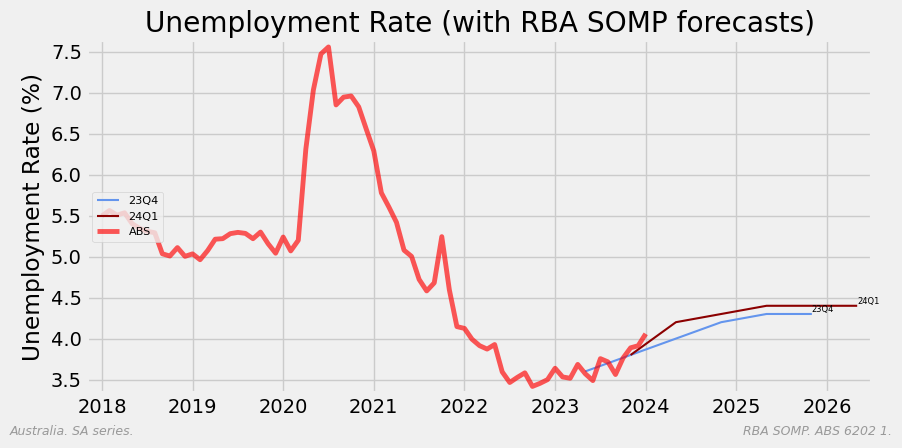

In [21]:
plot_ue()

### Number in Employment

This looks like a quarterly average in SOMP

In [22]:
# Force E data to be quarterly
E_QUARTERLY = False


def plot_employment():
    """Plot the SOMP Employment forecasts."""

    e_text = "Employment"
    e_measure = {
        e_text: Selector(
            catalog_id="6202",
            table="1",
            orig_sa="SA",
            search1="Employed total ;",
            search2="Persons",
            calc_growth=True,
        ),
    }

    e_data = get_abs(e_measure)
    if E_QUARTERLY:
        #  Convert monthly Employment data to Quarterly.
        e_data[e_text] = utility.monthly_to_qtly(e_data[e_text])

    plot_annual_growth(e_data, e_measure, somp)

Employment


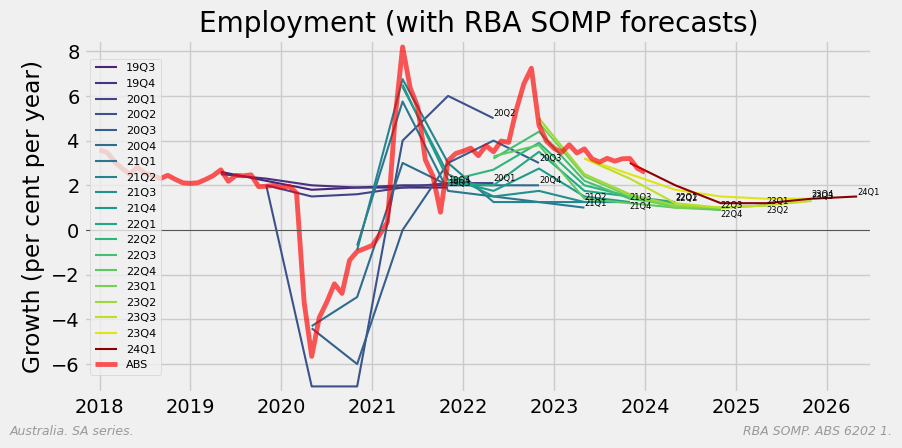

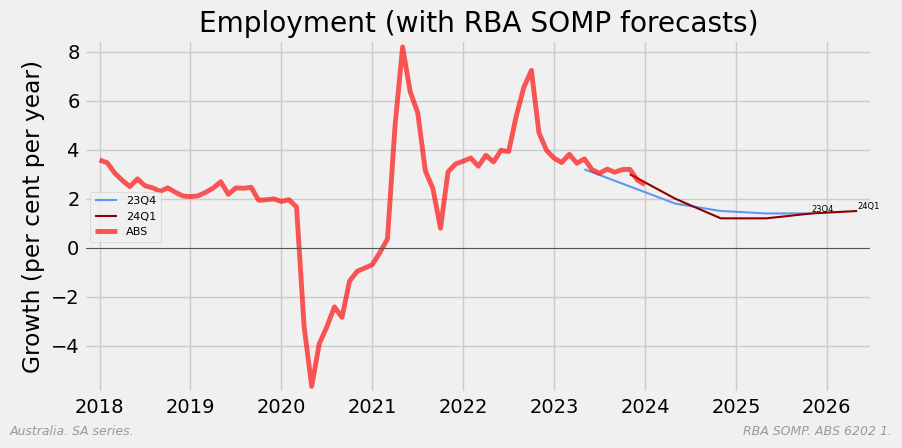

In [23]:
plot_employment()

### Cash rate

In [24]:
def plot_cr():
    """Produce a cash rate chart."""

    # plot the official cash rate history
    a2 = rba_data_capture.get_data("Monetary Policy Changes – A2")
    a2_meta, a2_data = a2 if a2 is not None else (None, None)
    target = "New Cash Rate Target"
    series_id = a2_meta[a2_meta.Title == target].index[0]
    ocr_rba = a2_data[series_id].to_period(freq="M")
    ocr_rba = ocr_rba[~ocr_rba.index.duplicated(keep="last")]
    new_index = pd.period_range(
        start=ocr_rba.index.min(), end=(pd.Timestamp.now().to_period(freq="M"))
    )
    ocr_rba = ocr_rba.reindex(new_index, fill_value=np.nan).ffill()
    ocr_rba = ocr_rba[ocr_rba.index.year >= START_YEAR]
    ax = ocr_rba.plot(
        drawstyle="steps-post", c="red", alpha=0.65, label="RBA Cash Rate"
    )

    # plot forward
    cr = "Cash Rate (%)"
    somp_cr = utility.qtly_to_monthly(somp[cr])
    plot_somp(ax, somp_cr)

    # and finalize
    finalise_plot(
        ax,
        title=f"{cr} (with forward market consensus)",
        ylabel=cr,
        lfooter="Australia.",
        rfooter="RBA SOMP.",
        legend={"ncols": 1, "loc": "center left", "fontsize": "xx-small"},
        y0=True,
        show=SHOW,
    )

Retrieving data from cache: RBA_CACHE/a296718e2fda7d15d3e636d9aca9c548--a02hist.xls


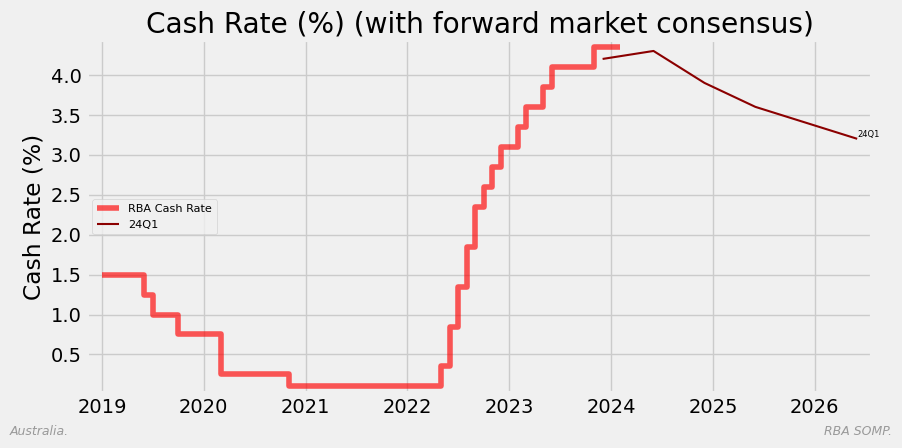

In [25]:
plot_cr()

## Finished

In [26]:
%load_ext watermark
%watermark -u -n -t -v -iv -w

Last updated: Fri Feb 16 2024 12:37:03

Python implementation: CPython
Python version       : 3.11.7
IPython version      : 8.21.0

numpy     : 1.26.4
pandas    : 2.2.0
matplotlib: 3.8.3

Watermark: 2.4.3



In [27]:
print("Finished.")

Finished.
